# 딥러닝 프로젝트 1. 가위바위보를 맞혀봐~

1. 목표: 나의 가위바위보 사진을 학습하여, 가위바위보 인식(분류) 모델 만들기
2. 데이터: 웹캠을 통해 촬영한 오른손 & 왼손 사진 총 300장 (가위 100, 바위 100, 보 100)
3. 데이터 변환: 28x28 리사이즈 변환 및 x_train / 255.0 으로 정규화
4. 테스트셋: 1) 나의 데이터 중 20% 분리(자체 테스트), 2) LMS 제공 data.zip 활용 (외부 테스트)
5. 모델 구축(CNN) 및 성능 확인 (*Conv-Pool-Conv-Pool-Flatten-Dense-Dropout 0.25-Dense)
    - 나의 데이터셋으로 훈련 및 평가 (accuracy: 0.7033 *n_channel_1=32, n_channel_2=64, n_dense=128, n_train_epoch=10)
    - 파라미터 수정을 통한 성능 개선 (accuracy: 0.8733 *n_channel_1=64, n_channel_2=128, n_dense=256, n_train_epoch=20)
    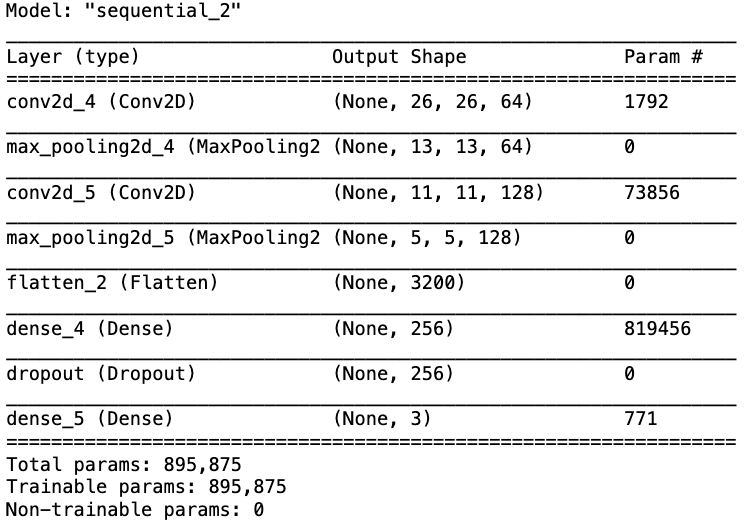
    - 나의 데이터셋 중 자체 테스트셋(20%) 평가 (accuracy: 0.9667) => 과적합인 듯..
    - LMS 데이터셋 평가 (accuracy: 0.3167)
6. 결과: 훈련 데이터에 대한 성능은 매우 높으나, 외부 데이터에 대한 성능이 무작위 추측 수준으로 급락하며 심각한 과적합 보임
7. 추가 활동
    - Dropout 강화 (기존 0.25 -> 변경 0.4) -> LMS 데이터셋 테스트 accuracy: 0.5400 \
      => 실험 중 최고 점수이나, 무작위 확률이나 다름없는 수치로 실패
      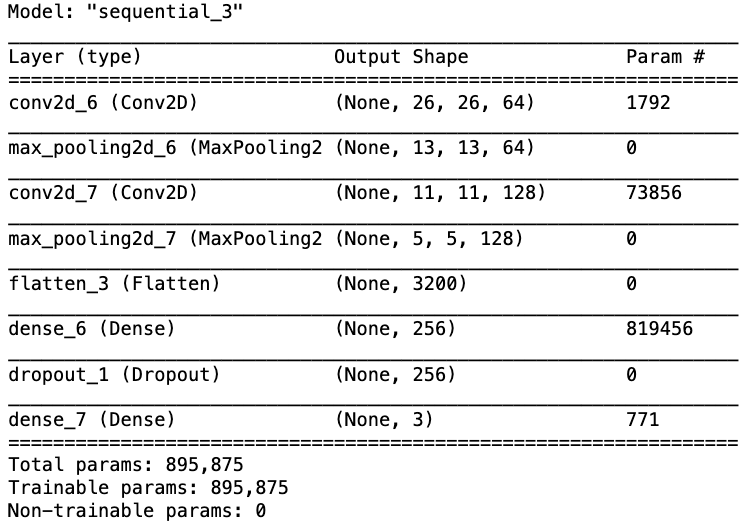
    - 데이터 증강 -> 훈련 데이터에 좌우 반전, 무작위 밝기/명암 조절 적용 -> accuracy: 0.3833 실패
8. 최종 모델 정리
    --------------------------------------------------
    🥇 재훈련 모델 성능 결과 \
    모델명: final_cnn_restart \
    LMS 테스트 데이터셋 Loss: 1.1075 \
    LMS 테스트 데이터셋 Accuracy: 0.5433 (54.33%) \
    -------------------------------------------------- \
    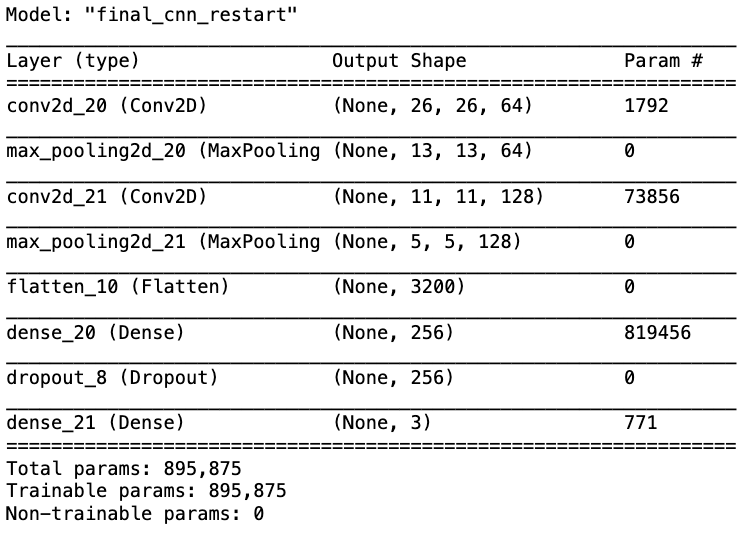

9. 회고
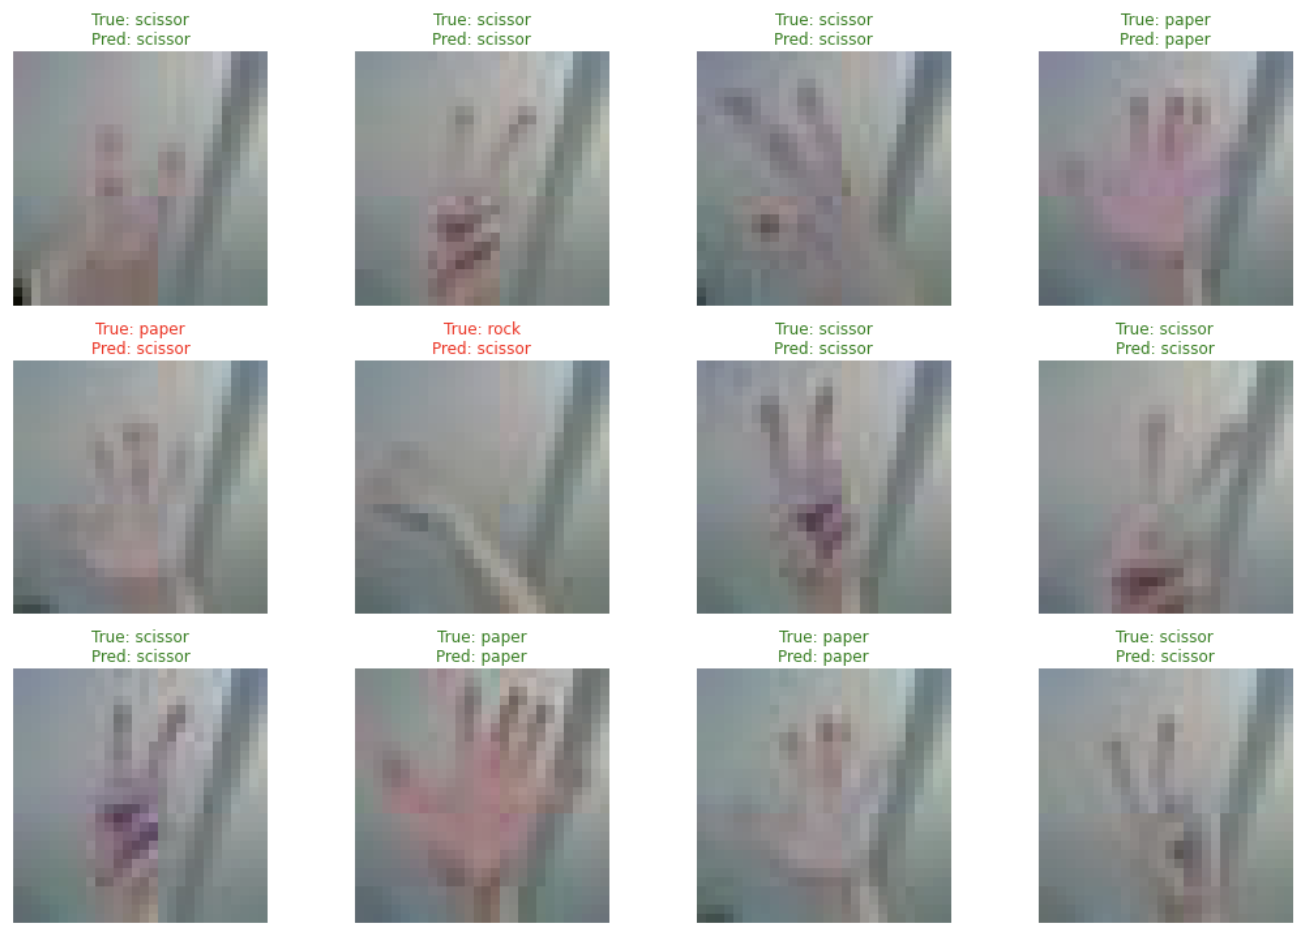
    - 데이터셋 300개는 딥러닝으로 모델을 학습 시키기에는 너무 적어 하이퍼파라미터 튜닝 과정에서 과적합을 유발할 수 있다고 판단 \
       더 많은 데이터셋 필요하지 않을까 함 (혹은 초기 모델 성능 점검 전 데이터 증강을 통해 데이터셋 다양화 필요)
    - 리사이징을 하면서 화질(해상도)이 너무 많이 낮아진 것도 하나의 문제로 예상됨
    - epoch를 늘린다고 해서 더 좋은 성능이 나오지 않음을 직접 경험함 (모델이 암기하게 만들어 성능 하락 유발)

# 이미지 파일 불러오기

In [2]:
from PIL import Image
import os
import glob
import numpy as np

# 1. 기본 경로 설정
base_dir = '~/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper'
# 실제 경로로 변환 (사용자 홈 디렉토리 ~ 처리)
base_dir = os.path.expanduser(base_dir)

# 2. 크기를 확인할 폴더 목록
folders = ['paper', 'scissor', 'rock']

# 3. 각 폴더의 첫 번째 이미지 크기 확인
print("--- 폴더별 첫 번째 이미지 크기 확인 ---")

for folder in folders:
    # 해당 폴더의 모든 jpg 파일 목록을 가져옴
    search_path = os.path.join(base_dir, folder, '*.jpg')
    image_list = glob.glob(search_path)
    
    if image_list:
        # 첫 번째 이미지 파일 경로
        first_image_path = image_list[0]
        
        # PIL을 사용하여 이미지 열기
        img = Image.open(first_image_path)
        
        # 이미지의 크기 (Width, Height) 출력
        print(f"[{folder}]: {first_image_path.split('/')[-1]}")
        print(f"   Image Size: {img.size} (Width, Height)")
    else:
        print(f"[{folder}]: 폴더에 이미지 파일이 없습니다.")

--- 폴더별 첫 번째 이미지 크기 확인 ---
[paper]: 42.jpg
   Image Size: (224, 224) (Width, Height)
[scissor]: 42.jpg
   Image Size: (224, 224) (Width, Height)
[rock]: 42.jpg
   Image Size: (224, 224) (Width, Height)


In [3]:
# 28x28 사이즈로 변경 함수 정의 (가이드코드에서 사이즈 변경 후, 덮어쓰기로 코드 변경)
def resize_images_and_overwrite(img_dir_path):
    """
    주어진 디렉토리의 모든 JPG 파일을 28x28 크기로 변경하고 원본 파일을 덮어씁니다.
    """
    # 덮어쓰기 경고
    print(f"\n🚨 [경고] 다음 경로의 파일을 덮어씁니다: {img_dir_path}")
    
    # 이미지 파일 목록 로드
    images = glob.glob(img_dir_path + "/*.jpg")
    
    # jpg 파일이 아닌 이미지가 포함된 경우를 위해 *.jpg 대신 *.* 를 사용할 수도 있습니다.
    
    print(f"총 {len(images)}개의 이미지를 28x28로 리사이징합니다.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    
    count = 0
    for img_path in images:
        try:
            old_img = Image.open(img_path)
            # 💡 Image.ANTIALIAS 대신 Image.LANCZOS 적용
            # Image.LANCZOS는 고품질 축소에 적합한 리샘플링 필터
            new_img = old_img.resize(target_size, Image.LANCZOS)
            new_img.save(img_path, "JPEG")
            count += 1
        except Exception as e:
            print(f"이미지 처리 중 오류 발생: {img_path} - {e}")
            
    print(f"✅ 총 {count}개의 이미지가 성공적으로 28x28로 리사이징 및 덮어쓰기 완료되었습니다.")
    print("-" * 30)


# 모든 폴더에 적용
base_path = os.path.expanduser("~/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper/")
folders = ['scissor', 'rock', 'paper']

print("--- 28x28 리사이징 시작 (원본 덮어쓰기) ---")

for folder in folders:
    # 각 카테고리별 이미지 디렉토리 경로 설정
    image_dir_path = os.path.join(base_path, folder)
    
    # 함수 실행
    resize_images_and_overwrite(image_dir_path)

print("--- 모든 가위, 바위, 보 이미지 resize 완료! ---")

--- 28x28 리사이징 시작 (원본 덮어쓰기) ---

🚨 [경고] 다음 경로의 파일을 덮어씁니다: /aiffel/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper/scissor
총 100개의 이미지를 28x28로 리사이징합니다.
✅ 총 100개의 이미지가 성공적으로 28x28로 리사이징 및 덮어쓰기 완료되었습니다.
------------------------------

🚨 [경고] 다음 경로의 파일을 덮어씁니다: /aiffel/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper/rock
총 100개의 이미지를 28x28로 리사이징합니다.
✅ 총 100개의 이미지가 성공적으로 28x28로 리사이징 및 덮어쓰기 완료되었습니다.
------------------------------

🚨 [경고] 다음 경로의 파일을 덮어씁니다: /aiffel/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper/paper
총 100개의 이미지를 28x28로 리사이징합니다.
✅ 총 100개의 이미지가 성공적으로 28x28로 리사이징 및 덮어쓰기 완료되었습니다.
------------------------------
--- 모든 가위, 바위, 보 이미지 resize 완료! ---


# 가위바위보 이미지 변환하기 (28x28)

In [4]:
# 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수 정의
def load_data(img_path, number_of_data):  
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size = 28
    color = 3 # RGB 컬러 이미지이므로 3 (흑백이었다면 1)
    
    # 이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0
    
    # --- Scissor 로드: 라벨 0 ---
    # glob.iglob은 generator를 반환하며, 메모리 효율적입니다.
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        # Image.open(file)로 이미지를 열고, np.array로 변환하면 (28, 28, 3) 배열이 됩니다.
        img = np.array(Image.open(file), dtype=np.int32) 
        imgs[idx, :, :, :] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1

    # --- Rock 로드: 라벨 1 ---
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1  
    
    # --- Paper 로드: 라벨 2 ---
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

# 경로 설정 및 함수 실행
my_image_dir_path = os.path.expanduser("~/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper")

total_data_count = 300 

(x_train, y_train) = load_data(my_image_dir_path, number_of_data=total_data_count)


# 정규화 (Normalization)
# 이미지 픽셀 값을 255로 나누는 과정은 딥러닝에서 필수적인 정규화(Normalization) 작업
# 일반적인 컬러 이미지(RGB)에서 각 픽셀의 밝기 값은 0부터 255까지의 정수로 표현
# x_train은 np.int32였으므로, 정규화를 위해 자료형을 float으로 변환
x_train_norm = x_train / 255.0

print("-" * 30)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("정규화된 x_train_norm의 최소값: {:.2f}, 최대값: {:.2f}".format(x_train_norm.min(), x_train_norm.max()))

학습데이터(x_train)의 이미지 개수는 300 입니다.
------------------------------
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
정규화된 x_train_norm의 최소값: 0.00, 최대값: 1.00


라벨:  0


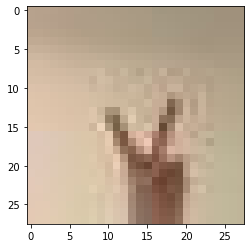

In [5]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

라벨:  1


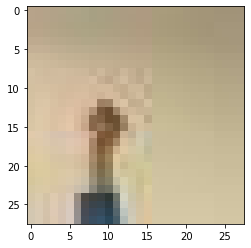

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_train[105])
print('라벨: ', y_train[105])

# 가위바위보 인식 모델 설계

가위바위보 데이터셋은 기존의 MINIST 손글씨 데이터셋과 아래의 차이점을 가짐

| 특징             | MNIST (손글씨)       | 가위바위보 (RPS)        | 코드                                     |
|:-----------------|:-------------------|:------------------------|:------------------------------------------------|
| 입력 채널 (Color) | 1 (흑백/grayscale) | 3 (RGB 컬러)           | input_shape=(28,28,**3**)                     |
| 출력 클래스       | 10 (숫자 0~9)       | 3 (가위, 바위, 보)     | keras.layers.Dense(**3**, activation='softmax') |

In [8]:
import tensorflow as tf
from tensorflow import keras

# 하이퍼파라미터 설정
n_channel_1=32
n_channel_2=64
n_dense=128
n_train_epoch=10

model = keras.models.Sequential()

# 1. 첫 번째 합성곱 레이어 (Conv2D)
# 입력 크기: (28, 28, 3) - 3채널(RGB)임을 명시
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))

# 2. 두 번째 합성곱 레이어
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

# 3. 데이터 평탄화 (Flatten)
# 2차원 특징 맵을 1차원 벡터로 변환
model.add(keras.layers.Flatten())

# 4. Dense 레이어 (특징 학습)
model.add(keras.layers.Dense(n_dense, activation='relu'))

# 5. 출력 레이어 (Classification)
# 출력 노드 수: 3 (가위=0, 바위=1, 보=2)
# 다중 클래스 분류이므로 'softmax' 활성화 함수 사용
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 구조 요약 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

# 딥러닝 네트워크 학습시키기

In [9]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

Epoch 1/10
10/10 [==============================] - 1s 36ms/step - loss: 1.1229 - accuracy: 0.2667
Epoch 2/10
10/10 [==============================] - 0s 36ms/step - loss: 1.0930 - accuracy: 0.3700
Epoch 3/10
10/10 [==============================] - 0s 34ms/step - loss: 1.0680 - accuracy: 0.5067
Epoch 4/10
10/10 [==============================] - 0s 46ms/step - loss: 1.0240 - accuracy: 0.5767
Epoch 5/10
10/10 [==============================] - 0s 38ms/step - loss: 0.9317 - accuracy: 0.6467
Epoch 6/10
10/10 [==============================] - 0s 38ms/step - loss: 0.8393 - accuracy: 0.6633
Epoch 7/10
10/10 [==============================] - 0s 34ms/step - loss: 0.8509 - accuracy: 0.6267
Epoch 8/10
10/10 [==============================] - 0s 35ms/step - loss: 0.8908 - accuracy: 0.5733
Epoch 9/10
10/10 [==============================] - 0s 35ms/step - loss: 0.7582 - accuracy: 0.6633
Epoch 10/10
10/10 [==============================] - 0s 35ms/step - loss: 0.6848 - accuracy: 0.7033


# 성능 개선 목표 하이퍼파라미터 수정

In [10]:
# --- 수정된 하이퍼파라미터 설정 ---
n_channel_1=64   # 32 -> 64
n_channel_2=128  # 64 -> 128
n_dense=256    # 128 -> 256
n_train_epoch=20 # 10 -> 20

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=n_train_epoch) 

model.summary()

Epoch 1/20
10/10 [==============================] - 1s 88ms/step - loss: 1.1547 - accuracy: 0.3600
Epoch 2/20
10/10 [==============================] - 1s 86ms/step - loss: 1.1005 - accuracy: 0.3133
Epoch 3/20
10/10 [==============================] - 1s 88ms/step - loss: 1.0953 - accuracy: 0.4067
Epoch 4/20
10/10 [==============================] - 1s 85ms/step - loss: 1.0898 - accuracy: 0.3700
Epoch 5/20
10/10 [==============================] - 1s 96ms/step - loss: 1.0893 - accuracy: 0.4233
Epoch 6/20
10/10 [==============================] - 1s 98ms/step - loss: 1.0455 - accuracy: 0.5067
Epoch 7/20
10/10 [==============================] - 1s 86ms/step - loss: 1.0079 - accuracy: 0.5300
Epoch 8/20
10/10 [==============================] - 1s 86ms/step - loss: 0.9455 - accuracy: 0.5900
Epoch 9/20
10/10 [==============================] - 1s 84ms/step - loss: 0.8792 - accuracy: 0.5833
Epoch 10/20
10/10 [==============================] - 1s 88ms/step - loss: 0.8071 - accuracy: 0.6500
Epoch 11/

# 내 데이터셋에서 일부 train - test 분리하여 성능 확인 (8:2)

In [11]:
from sklearn.model_selection import train_test_split

# 전체 데이터 (x_train_norm, y_train)를 훈련 세트와 시험 세트로 분리
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_train_norm, 
    y_train, 
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"훈련 데이터 개수: {len(x_train_split)}")
print(f"시험 데이터 개수: {len(x_test_split)}")

훈련 데이터 개수: 240
시험 데이터 개수: 60


In [12]:
# 훈련 (분리된 데이터 사용)
print("--- 분리된 데이터로 모델 재훈련 시작 ---")
# n_train_epoch를 20으로 설정하여 재훈련합니다.
model.fit(x_train_split, y_train_split, epochs=n_train_epoch) 

# 시험용 데이터로 모델 평가
print("\n--- 시험용 데이터로 모델 평가 ---")
test_loss, test_accuracy = model.evaluate(x_test_split, y_test_split, verbose=2)

print(f"시험 Loss: {test_loss:.4f}")
print(f"시험 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

--- 분리된 데이터로 모델 재훈련 시작 ---
Epoch 1/20
8/8 [==============================] - 1s 86ms/step - loss: 0.3227 - accuracy: 0.8833
Epoch 2/20
8/8 [==============================] - 1s 89ms/step - loss: 0.3119 - accuracy: 0.8875
Epoch 3/20
8/8 [==============================] - 1s 90ms/step - loss: 0.3065 - accuracy: 0.9042
Epoch 4/20
8/8 [==============================] - 1s 86ms/step - loss: 0.2699 - accuracy: 0.9208
Epoch 5/20
8/8 [==============================] - 1s 87ms/step - loss: 0.2485 - accuracy: 0.9167
Epoch 6/20
8/8 [==============================] - 1s 82ms/step - loss: 0.1949 - accuracy: 0.9417
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 0.1695 - accuracy: 0.9458
Epoch 8/20
8/8 [==============================] - 1s 86ms/step - loss: 0.1541 - accuracy: 0.9542
Epoch 9/20
8/8 [==============================] - 1s 93ms/step - loss: 0.1629 - accuracy: 0.9292
Epoch 10/20
8/8 [==============================] - 1s 86ms/step - loss: 0.1860 - accuracy: 0.9375
Ep

# LMS 데이터셋으로 테스트 해보기

## 데이터 로드

In [13]:
import os
import zipfile
import shutil

# 테스트셋 경로
original_data_path = os.path.expanduser("~/data/data.zip")

# 나의 작업 경로
base_dir = os.path.expanduser("~/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper")
test_data_dir = os.path.join(base_dir, "test_data_from_LMS")

# 기존 test_data_dir이 있으면 삭제 후 새로 생성
if os.path.exists(test_data_dir):
    shutil.rmtree(test_data_dir)
os.makedirs(test_data_dir)

print(f"LMS 테스트 데이터셋 압축 해제 경로: {test_data_dir}")
print("-" * 30)

# --- 데이터 압축 해제 ---
try:
    with zipfile.ZipFile(original_data_path, 'r') as zip_ref:
        zip_ref.extractall(test_data_dir)
    print("✅ 데이터 압축 해제 완료!")

except FileNotFoundError:
    print(f"❌ 오류: {original_data_path} 경로에 data.zip 파일이 없습니다. 경로를 확인해주세요.")
    # 이 경우, 이후 코드는 실행할 수 없습니다.
except Exception as e:
    print(f"❌ 오류 발생: 압축 해제 중 문제 발생: {e}")

LMS 테스트 데이터셋 압축 해제 경로: /aiffel/aiffel/workplace/2025-12-02_DeepLearning/rock_scissor_paper/test_data_from_LMS
------------------------------
✅ 데이터 압축 해제 완료!


##  LMS 테스트 데이터셋 리사이즈 및 덮어쓰기

In [14]:
from PIL import Image
import glob

def resize_images_and_overwrite(img_dir_path):
    """주어진 디렉토리의 모든 JPG 파일을 28x28 크기로 변경하고 원본 파일을 덮어씁니다."""
    images = glob.glob(img_dir_path + "/*.jpg")
    if not images:
        print("  - 이미지 파일이 없습니다. (스키핑)")
        return
        
    target_size = (28, 28)
    count = 0
    
    for img_path in images:
        try:
            old_img = Image.open(img_path)
            new_img = old_img.resize(target_size, Image.ANTIALIAS)
            new_img.save(img_path, "JPEG")
            count += 1
        except Exception as e:
            print(f"  - 오류 발생: {img_path} - {e}")
            
    print(f"  - 총 {count}개의 이미지가 28x28로 리사이징 및 덮어쓰기 완료.")

# 압축 해제된 폴더 내의 각 카테고리 폴더에 대해 리사이징 실행
test_folders = ['scissor', 'rock', 'paper']

print("\n--- 테스트 데이터 리사이징 시작 (28x28) ---")
for folder in test_folders:
    folder_path = os.path.join(test_data_dir, folder)
    print(f"➡️ {folder} 폴더 작업 중...")
    if os.path.exists(folder_path):
        resize_images_and_overwrite(folder_path)
    else:
        print(f"❌ 오류: 압축 해제된 데이터에 {folder} 폴더가 없습니다.")


--- 테스트 데이터 리사이징 시작 (28x28) ---
➡️ scissor 폴더 작업 중...
  - 총 100개의 이미지가 28x28로 리사이징 및 덮어쓰기 완료.
➡️ rock 폴더 작업 중...
  - 총 100개의 이미지가 28x28로 리사이징 및 덮어쓰기 완료.
➡️ paper 폴더 작업 중...
  - 총 100개의 이미지가 28x28로 리사이징 및 덮어쓰기 완료.


##  LMS 테스트 데이터셋 로드 및 정규화

In [15]:
LMS_data_count = 300 

print("\n--- 테스트 데이터 로드 및 정규화 ---")
try:
    (x_test_LMS, y_test_LMS) = load_data(test_data_dir, number_of_data=LMS_data_count)
    
    # 정규화
    x_test_LMS_norm = x_test_LMS / 255.0
    
    print(f"테스트 데이터셋 로드 완료: {x_test_LMS_norm.shape}")
    
except NameError:
    print("❌ 오류: load_data 함수가 정의되지 않았습니다. 이전 단계의 load_data 함수 정의 코드를 여기에 붙여 넣어주세요.")
except Exception as e:
    print(f"❌ 오류: 테스트 데이터 로드 중 문제 발생: {e}")


--- 테스트 데이터 로드 및 정규화 ---
학습데이터(x_train)의 이미지 개수는 300 입니다.
테스트 데이터셋 로드 완료: (300, 28, 28, 3)


라벨:  0


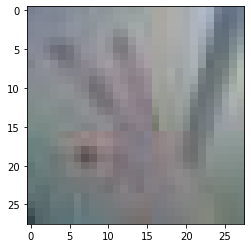

In [16]:
import matplotlib.pyplot as plt

plt.imshow(x_test_LMS[0])
print('라벨: ', y_test_LMS[0])

##  LMS 테스트 데이터셋 기반 나의 모델 성능 평가

In [17]:
if 'x_test_LMS_norm' in locals():
    print("\n--- LMS 테스트 데이터셋으로 최종 평가 ---")
    
    test_loss_inst, test_accuracy_inst = model.evaluate(
        x_test_LMS_norm, 
        y_test_LMS, 
        verbose=2
    )
    
    print("-" * 30)
    print(f"LMS 데이터셋 Loss: {test_loss_inst:.4f}")
    print(f"LMS 데이터셋 Accuracy: {test_accuracy_inst:.4f} ({test_accuracy_inst*100:.2f}%)")
    
else:
    print("❌ 오류: 테스트 데이터 로드가 성공하지 않아 평가를 진행할 수 없습니다.")


--- LMS 테스트 데이터셋으로 최종 평가 ---
10/10 - 0s - loss: 3.6018 - accuracy: 0.3167
------------------------------
LMS 데이터셋 Loss: 3.6018
LMS 데이터셋 Accuracy: 0.3167 (31.67%)


- 나의 모델은 300장 사진에 대해 심각한 과적합 상태가 예상됨 (아주 높은 가능성)
- 일반화 능력 강화를 위한 모델 수정

# 과적합 문제 해결..

In [18]:
# --- 수정된 하이퍼파라미터 설정 ---
n_channel_1=64
n_channel_2=128
n_dense=256
n_train_epoch=20 # 에포크 횟수는 20으로 유지

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
# 🚨 Dropout 강화 (0.25 -> 0.4)
#인공신경망(Artificial Neural Network, ANN)의 과적합(Overfitting)을 방지하기 위해 사용하는 정규화(Regularization) 기법 중 하나
# - 비활성화 비율: 신경망의 일부 뉴런을 무작위로 선택하여 일시적으로 비활성화(제거), 일반적으로 0.2~0.5
model.add(keras.layers.Dropout(0.4)) 
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [19]:
# --- 훈련 시작 (분리된 데이터 사용) ---
print("\n--- Dropout 0.4 모델 재훈련 시작 (총 {} 에포크) ---".format(n_train_epoch))
model.fit(x_train_split, y_train_split, epochs=n_train_epoch, verbose=1) 

print("\n--- LMS 테스트 데이터셋으로 최종 평가 ---")
test_loss_inst, test_accuracy_inst = model.evaluate(
    x_test_LMS_norm, 
    y_test_LMS, 
    verbose=2
)

print("-" * 30)
print(f"LMS 데이터셋 Loss: {test_loss_inst:.4f}")
print(f"LMS 데이터셋 Accuracy: {test_accuracy_inst:.4f} ({test_accuracy_inst*100:.2f}%)")


--- Dropout 0.4 모델 재훈련 시작 (총 20 에포크) ---
Epoch 1/20
8/8 [==============================] - 1s 90ms/step - loss: 1.1455 - accuracy: 0.3500
Epoch 2/20
8/8 [==============================] - 1s 86ms/step - loss: 1.1113 - accuracy: 0.3250
Epoch 3/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0933 - accuracy: 0.4083
Epoch 4/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0758 - accuracy: 0.4167
Epoch 5/20
8/8 [==============================] - 1s 88ms/step - loss: 1.0697 - accuracy: 0.4125
Epoch 6/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0317 - accuracy: 0.4583
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 0.9717 - accuracy: 0.5292
Epoch 8/20
8/8 [==============================] - 1s 85ms/step - loss: 0.9149 - accuracy: 0.5750
Epoch 9/20
8/8 [==============================] - 1s 88ms/step - loss: 0.8864 - accuracy: 0.5208
Epoch 10/20
8/8 [==============================] - 1s 85ms/step - loss: 0.8703 - accu

# 훈련 데이터를 인위적으로 다양하게 만들기 - 데이터 증강(data augmentation)
- 이미지를 회전, 이동, 확대/축소, 좌우 반전, 밝기 조절, 명암 조절 등을 적용하여 모델이 실제 데이터의 다양성을 학습하도록 강제

In [20]:
# 1. 🛠️ 모델 재정의 (Dropout 0.4 유지)
# Dropout 0.4 모델 구조를 다시 한 번 확인합니다.
n_channel_1=64
n_channel_2=128
n_dense=256
n_train_epoch=20

model = keras.models.Sequential([
    keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(n_dense, activation='relu'),
    keras.layers.Dropout(0.4), # 강화된 Dropout
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 2. 🤖 데이터 증강 함수 정의
def augment_data(image, label):
    # 2-1. 좌우 반전
    image = tf.image.random_flip_left_right(image)
    
    # 2-2. 무작위 밝기 조절 (최대 20% 변화)
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # 2-3. 무작위 명암 조절 (80% ~ 120% 변화)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # 2-4. 무작위 회전/이동 등은 복잡하므로 여기서는 간단한 변환만 적용합니다.
    
    # 증강 후 클리핑 (정규화 범위 0.0 ~ 1.0 유지)
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

# 3. 💾 증강된 데이터셋 생성
# x_train_split, y_train_split은 이전에 분리된 훈련 데이터라고 가정
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_split.astype(np.float32), y_train_split))
train_dataset = train_dataset.map(augment_data) # 증강 적용
train_dataset = train_dataset.shuffle(buffer_size=len(x_train_split)).batch(32) # 섞기 및 배치 처리

# LMS 테스트 데이터셋도 tf.data.Dataset으로 변환 (평가 시 사용)
test_dataset_lms = tf.data.Dataset.from_tensor_slices((x_test_LMS_norm.astype(np.float32), y_test_LMS)).batch(32)


# 4. 🚀 모델 재훈련 (증강 데이터셋 사용)
print("\n--- 데이터 증강 모델 재훈련 시작 (총 {} 에포크) ---".format(n_train_epoch))
# 훈련 시 Dataset 객체를 전달합니다.
history = model.fit(train_dataset, epochs=n_train_epoch, verbose=1) 


# 5. 🥇 LMS 테스트 데이터셋으로 최종 평가
print("\n--- LMS 테스트 데이터셋으로 최종 평가 ---")

# 평가 시 Dataset 객체를 전달합니다.
test_loss_inst, test_accuracy_inst = model.evaluate(
    test_dataset_lms, 
    verbose=2
)

print("-" * 30)
print(f"LMS 데이터셋 Loss: {test_loss_inst:.4f}")
print(f"LMS 데이터셋 Accuracy: {test_accuracy_inst:.4f} ({test_accuracy_inst*100:.2f}%)")


--- 데이터 증강 모델 재훈련 시작 (총 20 에포크) ---
Epoch 1/20
8/8 [==============================] - 1s 87ms/step - loss: 1.1989 - accuracy: 0.2542
Epoch 2/20
8/8 [==============================] - 1s 83ms/step - loss: 1.1016 - accuracy: 0.3333
Epoch 3/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0924 - accuracy: 0.4458
Epoch 4/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0873 - accuracy: 0.4167
Epoch 5/20
8/8 [==============================] - 1s 95ms/step - loss: 1.0578 - accuracy: 0.4583
Epoch 6/20
8/8 [==============================] - 1s 109ms/step - loss: 1.1186 - accuracy: 0.3458
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0504 - accuracy: 0.4042
Epoch 8/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0102 - accuracy: 0.4542
Epoch 9/20
8/8 [==============================] - 1s 86ms/step - loss: 0.9796 - accuracy: 0.5333
Epoch 10/20
8/8 [==============================] - 1s 86ms/step - loss: 0.9429 - accuracy

# 최종 모델 정리

In [32]:
# --- 1. 최종 모델 하이퍼파라미터 설정 ---
n_channel_1=64
n_channel_2=128
n_dense=256
n_train_epoch=20 

# --- 2. 모델 초기화 및 재정의 ---
model = keras.models.Sequential(name="final_cnn_restart") 

model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(0.4)) 
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("--- 새로운 모델 정의 및 초기화 완료 ---")


# --- 3. 데이터 증강 함수 및 Dataset 재정의 ---
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# LMS 테스트 데이터셋도 다시 tf.data.Dataset으로 변환 (평가 시 사용)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_split.astype(np.float32), y_train_split))
train_dataset = train_dataset.map(augment_data) 
train_dataset = train_dataset.shuffle(buffer_size=len(x_train_split)).batch(32)
test_dataset_lms = tf.data.Dataset.from_tensor_slices((x_test_LMS_norm.astype(np.float32), y_test_LMS)).batch(32)


# --- 4. 모델 훈련 시작 ---
print("\n--- 최종 모델 재훈련 시작 (총 {} 에포크, 데이터 증강 적용) ---".format(n_train_epoch))
model.fit(train_dataset, epochs=n_train_epoch, verbose=1)  
print("-" * 50)


# --- 5. 최종 LMS 테스트 평가 ---
print("\n--- LMS 테스트 데이터셋으로 최종 평가 ---")
test_loss_inst, test_accuracy_inst = model.evaluate(test_dataset_lms, verbose=2)
print("-" * 50)


# --- 6. 최종 점수 출력 ---
print("\n### 🥇 재훈련 모델 성능 결과 ###")
print(f"모델명: {model.name}")
print(f"LMS 테스트 데이터셋 Loss: {test_loss_inst:.4f}")
print(f"LMS 테스트 데이터셋 Accuracy: {test_accuracy_inst:.4f} ({test_accuracy_inst*100:.2f}%)")
print("-----------------------------------")

--- 새로운 모델 정의 및 초기화 완료 ---

--- 최종 모델 재훈련 시작 (총 20 에포크, 데이터 증강 적용) ---
Epoch 1/20
8/8 [==============================] - 1s 92ms/step - loss: 1.1382 - accuracy: 0.3583
Epoch 2/20
8/8 [==============================] - 1s 90ms/step - loss: 1.1044 - accuracy: 0.3083
Epoch 3/20
8/8 [==============================] - 1s 86ms/step - loss: 1.1006 - accuracy: 0.3375
Epoch 4/20
8/8 [==============================] - 1s 87ms/step - loss: 1.0859 - accuracy: 0.4375
Epoch 5/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0754 - accuracy: 0.4000
Epoch 6/20
8/8 [==============================] - 1s 115ms/step - loss: 1.0718 - accuracy: 0.4208
Epoch 7/20
8/8 [==============================] - 1s 86ms/step - loss: 1.0623 - accuracy: 0.3792
Epoch 8/20
8/8 [==============================] - 1s 87ms/step - loss: 1.0042 - accuracy: 0.5333
Epoch 9/20
8/8 [==============================] - 1s 89ms/step - loss: 0.9078 - accuracy: 0.6250
Epoch 10/20
8/8 [==============================] - 1s 8

In [33]:
model.summary()

Model: "final_cnn_restart"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               819456    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)         

# 최종 시각화

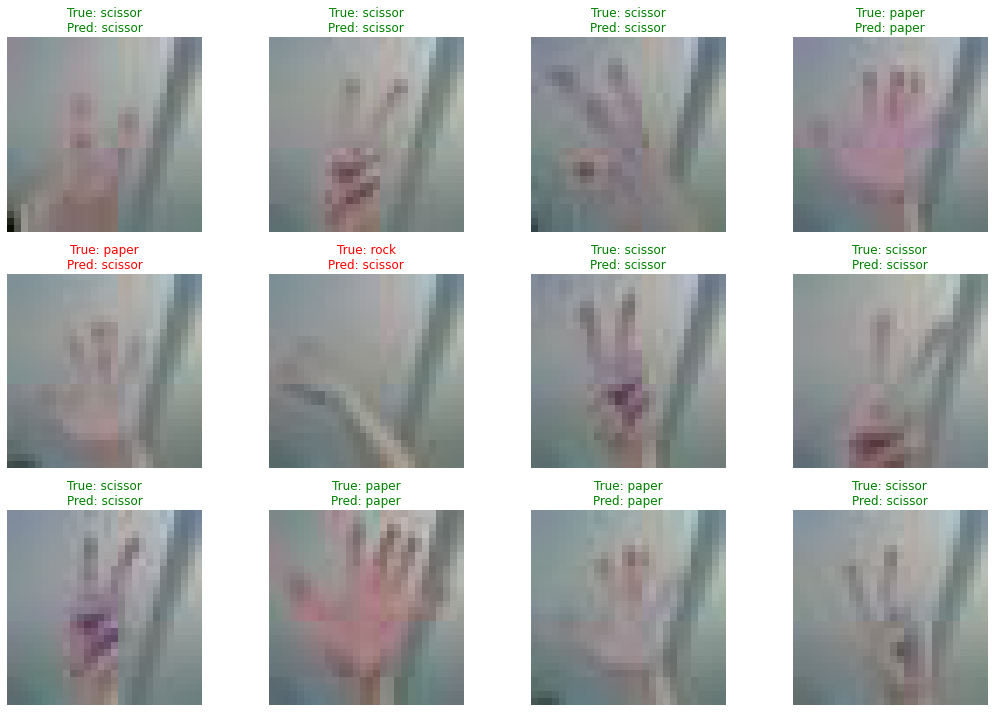

In [38]:
# 1. 변수 설정 및 준비

class_names = ['scissor', 'rock', 'paper']   # 0, 1, 2

x_test = x_test_LMS_norm
y_test = y_test_LMS

data_size = len(x_test) 

num_images = 12

# 0부터 data_size-1 사이에서 12개의 인덱스를 무작위로 추출
# replace=False로 설정하여 중복 없이 추출
random_indices = np.random.choice(data_size, num_images, replace=False)

# 모델 예측 (전체 LMS 테스트 데이터셋에 대해 예측을 수행)
# model은 최종 학습 완료된 final_cnn_restart 모델 객체
pred = model.predict(x_test)          # (N, 3) 형태의 예측 확률
pred_label = np.argmax(pred, axis=1)  # 예측된 라벨 인덱스 (0, 1, 2)

# 2. 시각화 설정 및 출력

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(3, 4, i+1)
    
    # 무작위 인덱스(idx)에 해당하는 이미지와 라벨 사용
    plt.imshow(x_test[idx]) 
    plt.axis('off')

    # 실제 라벨과 예측 라벨 가져오기
    true_label_idx = y_test[idx]
    pred_label_idx = pred_label[idx]
    
    true_name = class_names[true_label_idx]
    pred_name = class_names[pred_label_idx]

    # 정답 여부에 따라 색상 설정
    color = 'green' if true_label_idx == pred_label_idx else 'red'
    
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=12)

plt.tight_layout()
plt.show()